# Ploting tools for visualizing the data and simulations

## Maps with geopandas

In [206]:
%matplotlib inline

import matplotlib.pyplot as plt
import geopandas as gpd
import palettable as pltt
from seaborn import palplot
import pandas as pd
import sys

In [207]:
fname_shp = 'zip:///home/juanf/Work/Balearic-epi/data/Municipios_IGN.zip'
gdb_IB = gpd.read_file(fname_shp)
#gdb_IB.head()

In [349]:
gdb_IB['name_slug'] = None
for index, row in gdb_IB.iterrows():
    gdb_IB.loc[index, 'name_slug'] = slugify(row['NAMEUNIT']).replace('-','')
#gdb_IB.head()

In [350]:
db_pop = pd.read_csv('./data/ib_pob.csv', delimiter = ' ')
#db_pop.head()

In [351]:
db_pop['CODIGOINE'] = None
#db_pop.head()

In [352]:
good_name = {'castelles' : 'escastell',
             'deya' : 'deia',
             'mao' : 'maomahon',
             'mercadales' : 'esmercadal',
             'migjorngranes' : 'esmigjorngran',
             'poblasa' : 'sapobla',
             'salinesses' : 'sessalines',
             'santaeulaliadelrio' : 'santaeulariadesriu'
            }

slug_names = list(gdb_IB['name_slug'])
for index, row in db_pop.iterrows():
    name = slugify(db_pop.loc[index, 'NAMEUNIT'])
    if name in slug_names:
        db_pop.loc[index, 'CODIGOINE'] = gdb_IB.loc[gdb_IB['name_slug'] == name, 'CODIGOINE'].values[0]
        #print(name, gdb_IB.loc[gdb_IB['name_slug'] == name]['CODIGOINE'].values[0])
        #sys.exit()
    elif name in good_name.keys():
        db_pop.loc[index, 'CODIGOINE'] = gdb_IB.loc[gdb_IB['name_slug'] == good_name[name], 'CODIGOINE'].values[0]
    else:
        print(name)
#db_pop.head()

In [353]:
gdb_withpops = pd.merge(gdb_IB, db_pop, on="CODIGOINE")
#gdb_withpops.head()

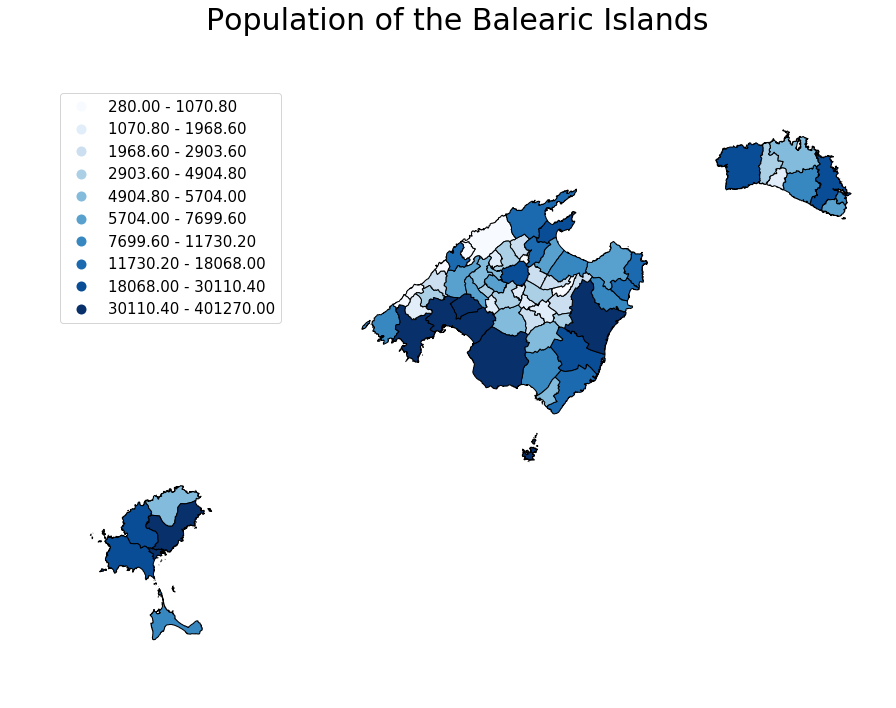

In [420]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(15, 11))
# Plot layer of polygons on the axis
#gdb_IB.plot(linewidth=0.1, facecolor='g', edgecolor='grey', ax=ax)
gdb_withpops_proj = gdb_withpops.to_crs("EPSG:2062")


gdb_withpops_proj.plot(column='pop', cmap=plt.cm.get_cmap('Blues') , scheme='quantiles', k=10, 
        legend=True, legend_kwds={'loc': 2, 'fontsize': 15}, ax=ax, linewidth = 1, edgecolor = 'k')
# Remove axis frames
ax.set_axis_off()
# Force axis to be on the same unit
plt.axis('equal')
# Add figure title
f.suptitle('Population of the Balearic Islands', fontsize = 30)
# Display
plt.show()

In [214]:
db_pop.head()

NAMEUNIT    pop  pop_male  pop_female    island CODIGOINE
0   Alaior   9257      4643        4614  Mallorca     07002
1    Alaró   5327      2629        2698   Menorca     07001
2  Alcudia  19071      9704        9367  Mallorca     07003
3  Algaida   5050      2632        2418  Mallorca     07004
4  Andratx  11685      5898        5787  Mallorca     07005

In [215]:
db_pop.to_csv('./data/ib_pob_INE.csv', sep = ' ')

## Bokeh interactive maps

In [416]:
import json
import numpy as np
from bokeh.io import show, output_notebook
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, LogColorMapper,
                          BasicTicker, LogTicker, PrintfTickFormatter)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer, mpl
from bokeh.plotting import figure, output_file

output_notebook()

# Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = gdb_withpops_proj.to_json())

# Define color palettes
palette = mpl['Viridis'][10]
palette = palette[::-1] # reverse order of colors so higher values have darker colors
# Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LogColorMapper(palette = palette, low = 200, high = 401270)
# Create color bar.
ticker = LogTicker(base = 5, desired_num_ticks = 10)
formatter = PrintfTickFormatter(format='%i')
color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0), 
                     orientation = 'horizontal',
                     ticker = ticker,
                     formatter = formatter,
                     title = 'Población')
# Create figure object.
p = figure(title = 'Población de las Islas Baleares', 
           plot_height = 600, plot_width = 800, 
           toolbar_location = 'below',
           tools = "pan, wheel_zoom, box_zoom, reset",
           match_aspect=True)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.
states = p.patches('xs','ys', source = geosource,
                   fill_color = {'field' :'pop',
                                 'transform' : color_mapper},
                   line_color = 'black', 
                   line_width = 1, 
                   fill_alpha = 1)
# Create hover tool
p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('Municipio','@NAMEUNIT_x'),
                               ('Población', '@pop')]))
p.xaxis.visible = False
p.yaxis.visible = False
p.title.text_font_size = '20pt'
# Specify layout
p.add_layout(color_bar, 'below')
# Output filepath
outfp = "./figures/ib_poblacion.html"

# Save the map
output_file(outfp, title = 'Población IB')
show(p)

Loading BokehJS ...

## Plot results from VME

Code for cleaning results files from VME. It gets read of leading and trailing spaces and converts groups of spaces into a single one. 
```bash
> awk '$1=$1' file
```

In [504]:
#load real data
df_epi = pd.read_csv('./data/data_new', sep = ' ')
df_epi.tail()

#Dia  muertos1  infectados  uci  muertos_oficial
10    25        19         660   43               17
11    26        22         755   46               22
12    27        26         862   59               26
13    28        33         958   71               29
14    29        33        1000   80               37

In [533]:
#load simulation data
df_simu_av = pd.read_csv('./results/time_ave_r_sd_i_sd_format0.csv', sep = ' ')
df_simu_av.head()
print(np.array(df_simu_av['average_recover'])*3.4)# 0.006 -> 36, resta 22; 3.4 -> 12, resta 2

[3.40000000e+00 3.40000000e+00 3.40000000e+00 3.40000000e+00
 5.44000000e+00 7.14000000e+00 8.50000000e+00 1.19000000e+01
 1.39400000e+01 1.90400000e+01 2.51600000e+01 3.16200000e+01
 3.87600000e+01 4.96400000e+01 6.49400000e+01 8.26200000e+01
 1.08120000e+02 1.39740000e+02 1.83600000e+02 2.34940000e+02
 3.02260000e+02 3.98820000e+02 5.10000000e+02 6.53820000e+02
 8.43200000e+02 1.08358000e+03 1.41848000e+03 1.81934000e+03
 2.34294000e+03 3.01886000e+03 3.89980000e+03 5.06532000e+03
 6.53990000e+03 8.47824000e+03 1.09109400e+04 1.40066400e+04
 1.80676000e+04 2.33199200e+04 2.99444800e+04 3.85257400e+04
 4.94428000e+04 6.33562800e+04 8.10781000e+04 1.03603100e+05
 1.32155960e+05 1.67675080e+05 2.11963820e+05 2.66461060e+05
 3.32456760e+05 4.11616920e+05 5.04950660e+05 6.11586220e+05
 7.31462740e+05 8.63124000e+05 1.00231558e+06 1.14504724e+06
 1.28709006e+06 1.42414270e+06 1.55357730e+06 1.67346844e+06
 1.78415272e+06 1.88596810e+06 1.98052686e+06 2.06929644e+06
 2.15272598e+06 2.234400

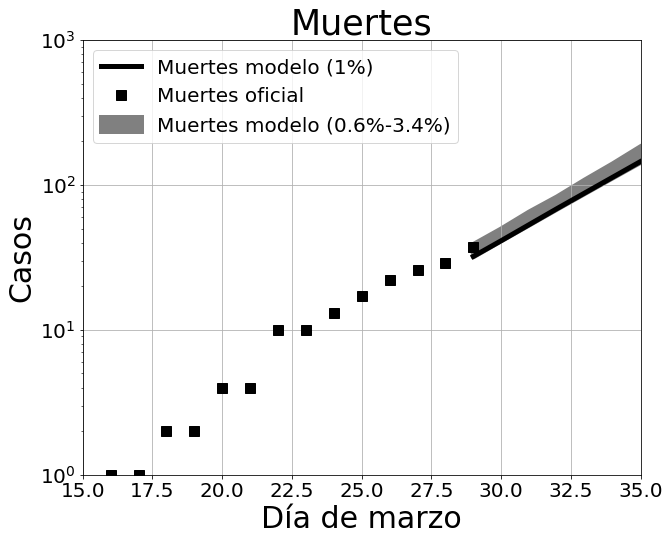

In [541]:
#datos reales
x = df_epi['#Dia']
y_m = list(df_epi['muertos1'])
y_inf = list(df_epi['infectados'])
y_m2 = list(df_epi['muertos_oficial'])
y_uci = list(df_epi['uci'])
#resultados modelo
x_model = np.array(df_simu_av['time'])
y_model = np.array(df_simu_av['average_recover'])
y_model_inf = np.array(df_simu_av['av_Infected'])
#print(y_model_inf/y_model_inf[49])
fig = plt.figure(figsize = (10, 8))
plt.plot(x_model[34:]-20, y_model[34:]*0.01, c = 'k', label= 'Muertes modelo (1%)', lw = 5)
plt.fill_between(x_model[36:]-22, y_model[36:]*0.006, y_model[12:len(y_model)-24]*3.4, color = 'gray', label= 'Muertes modelo (0.6%-3.4%)', lw = 5)
#plt.plot(x_model[34:]-20, y_model_inf[34:]*y_uci[-1]/y_model_inf[34], 'r--', label= 'UCI modelo', lw = 5)
#plt.plot(x_model-20, y_model_inf*y_inf[-1]/y_model_inf[34], c='r', label= 'Infectados modelo')
#plt.plot(x, y_m, 'ko', label = 'Muertes prensa')
#plt.plot(x, y_inf, 'r^', label = 'Infectados')
#plt.plot(x, y_uci, 'rX', label = 'UCI', ms = 10)
#plt.figsize((12, 12))
plt.plot(x, y_m2, 'ks', label = 'Muertes oficial', ms = 10)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día de marzo', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
plt.xlim((15,35))
plt.ylim((1,1000))
plt.title('Muertes', fontsize = 35)
plt.legend(fontsize = 20, loc = 2)
plt.savefig('./figures/muertes_29_03.png')

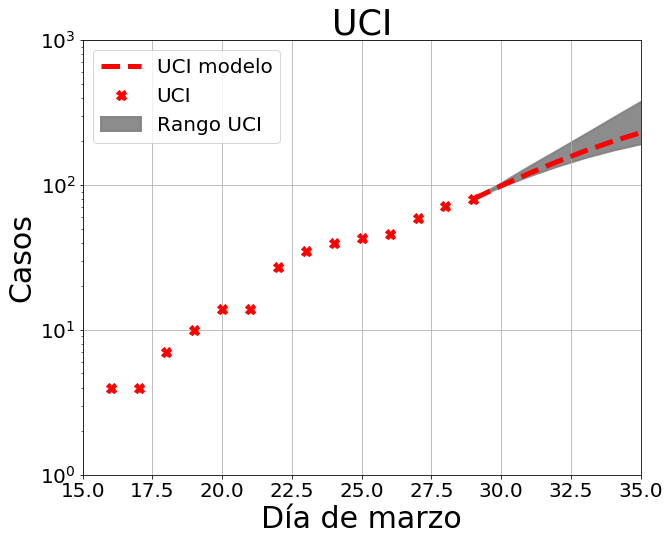

In [545]:
fig = plt.figure(figsize = (10, 8))
#plt.plot(x_model[34:]-20, y_model[34:]*0.01, c = 'k', label= 'Muertes modelo (1%)', lw = 5)
#plt.fill_between(x_model[36:]-22, y_model[36:]*0.006, y_model[12:len(y_model)-24]*3.4, color = 'gray', label= 'Muertes modelo (0.6%-3.4%)', lw = 5)
plt.plot(x_model[34:]-20, y_model_inf[34:]*y_uci[-1]/y_model_inf[34], 'r--', label= 'UCI modelo', lw = 5)
plt.fill_between(x_model[36:]-22, y_model_inf[36:]*y_uci[-1]/y_model_inf[36], y_model_inf[12:len(y_model)-24]*y_uci[-1]/y_model_inf[12], color = 'gray', label= 'Rango UCI modelo', lw = 2, alpha = 0.9)
#plt.plot(x_model-20, y_model_inf*y_inf[-1]/y_model_inf[34], c='r', label= 'Infectados modelo')
#plt.plot(x, y_m, 'ko', label = 'Muertes prensa')
#plt.plot(x, y_inf, 'r^', label = 'Infectados')
plt.plot(x, y_uci, 'rX', label = 'UCI', ms = 10)
#plt.figsize((12, 12))
#plt.plot(x, y_m2, 'ks', label = 'Muertes oficial', ms = 10)
ax = plt.gca()
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
plt.grid()
plt.yscale('log')
plt.xlabel('Día de marzo', fontsize = 30)
plt.ylabel('Casos', fontsize = 30)
plt.xlim((15,35))
plt.ylim((1,1000))
plt.title('UCI', fontsize = 35)
plt.legend(fontsize = 20, loc = 2)
plt.savefig('./figures/uci_29_03.png')

## Generate movie from simulation data

In [ ]:
import os
mencoder_order = "mencoder mf://*.png -mf w=800:h=600:fps=25:type=png -ovc lavc -lavcopts vcodec=mpeg4:mbd=2:trell -oac copy -o output.avi"

In [423]:
df_simu = pd.read_csv('./results/modelo029_ph4_format0.csv', sep = ' ')
df_simu.head()

irun  CODIGOINE  beta  time  recover
0     1          1  0.29     1        0
1     1          2  0.29     1        0
2     1          3  0.29     1        0
3     1          4  0.29     1        0
4     1          5  0.29     1        0

(-1, 1)

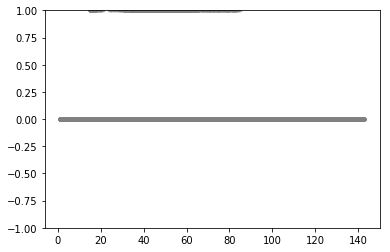

In [484]:
x = df_simu['time']
y = df_simu['recover']
plt.plot(x, y, '.', c= 'gray', alpha = 0.5)
plt.ylim((-1,1))
#plt.yscale('log')